<a href="https://colab.research.google.com/github/gabrielcampanile/Neural-Network/blob/main/Projeto%201%20-%20MLP/Projeto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === 1. Imports e leitura de dados ===
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score


In [ ]:
# === 2. Carregamento e pré-processamento ===
dataset = pd.read_csv('Matches.csv')
features = [
    'HomeElo', 'AwayElo',
    'Form3Home', 'Form3Home',
    'Form5Away', 'Form5Away',
    'OddHome', 'OddDraw', 'OddAway',
    'HandiSize',
    # 'HTHome', 'HTAway',
    ]
df = dataset[features + ['FTResult']].dropna().reset_index(drop=True)
X = StandardScaler().fit_transform(df[features])
y = LabelEncoder().fit_transform(df['FTResult'])


<ipython-input-124-75edf81ff16f>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('Matches.csv')


In [ ]:
# === 3. Divisão dos dados e conversão para Tensor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
y_train, y_test = torch.tensor(y_train, dtype=torch.long).to(device), torch.tensor(y_test, dtype=torch.long).to(device)

In [ ]:
# Rebalanceamento das classes com peso
unique, counts = np.unique(y_train.cpu().numpy(), return_counts=True)
print(dict(zip(unique, counts)))
class_counts = np.bincount(y_train.cpu().numpy())
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32).to(device)


{np.int64(0): np.int64(24757), np.int64(1): np.int64(23681), np.int64(2): np.int64(39388)}


In [ ]:
# === 4. Modelo ===
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[], output_size=3):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
# === 5. Função de treinamento ===
def train(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01, momentum=0):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    # loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_test)
            val_loss = loss_fn(val_preds, y_test)
            val_acc = accuracy_score(y_test.cpu(), torch.argmax(val_preds, dim=1).cpu())

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

    return history


In [ ]:
# === 6. Avaliação ===
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
    acc = accuracy_score(y_test.cpu(), preds.cpu())
    cm = confusion_matrix(y_test.cpu(), preds.cpu())
    print(f"Acurácia: {acc * 100:.2f}%")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()



== Arquitetura 1: [] ==
Epoch 0 - Loss: 1.2352 | Val Loss: 1.1904 | Val Acc: 0.3045
Epoch 100 - Loss: 1.0300 | Val Loss: 1.0352 | Val Acc: 0.4565
Epoch 200 - Loss: 1.0290 | Val Loss: 1.0339 | Val Acc: 0.4593
Epoch 300 - Loss: 1.0286 | Val Loss: 1.0333 | Val Acc: 0.4602
Epoch 400 - Loss: 1.0284 | Val Loss: 1.0329 | Val Acc: 0.4604
Acurácia: 46.09%


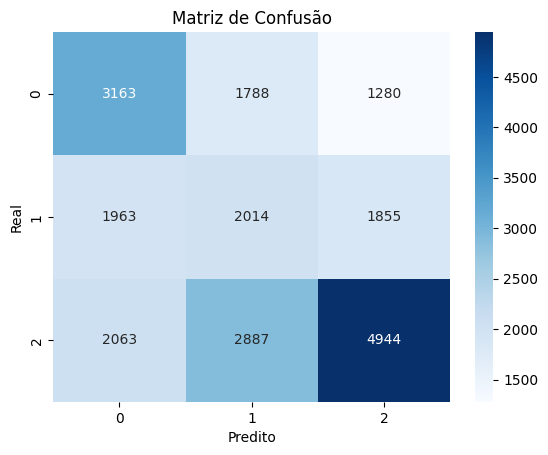


== Arquitetura 2: [10] ==
Epoch 0 - Loss: 1.1096 | Val Loss: 1.1029 | Val Acc: 0.3227
Epoch 100 - Loss: 1.0350 | Val Loss: 1.0380 | Val Acc: 0.4487
Epoch 200 - Loss: 1.0297 | Val Loss: 1.0339 | Val Acc: 0.4526
Epoch 300 - Loss: 1.0286 | Val Loss: 1.0329 | Val Acc: 0.4605
Epoch 400 - Loss: 1.0281 | Val Loss: 1.0324 | Val Acc: 0.4619
Acurácia: 46.27%


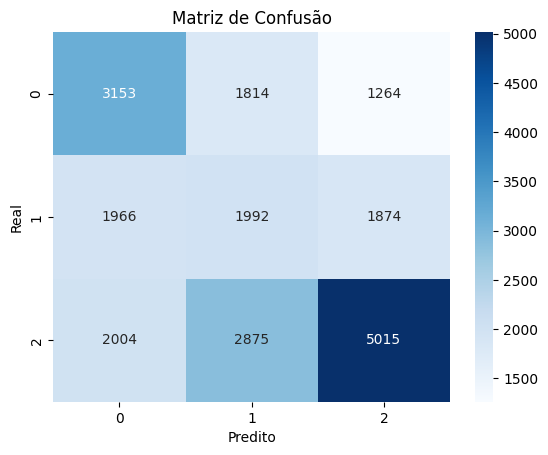


== Arquitetura 3: [20, 10] ==
Epoch 0 - Loss: 1.0952 | Val Loss: 1.0943 | Val Acc: 0.3116
Epoch 100 - Loss: 1.0553 | Val Loss: 1.0576 | Val Acc: 0.4651
Epoch 200 - Loss: 1.0383 | Val Loss: 1.0411 | Val Acc: 0.4653
Epoch 300 - Loss: 1.0313 | Val Loss: 1.0346 | Val Acc: 0.4637
Epoch 400 - Loss: 1.0295 | Val Loss: 1.0331 | Val Acc: 0.4613
Acurácia: 46.09%


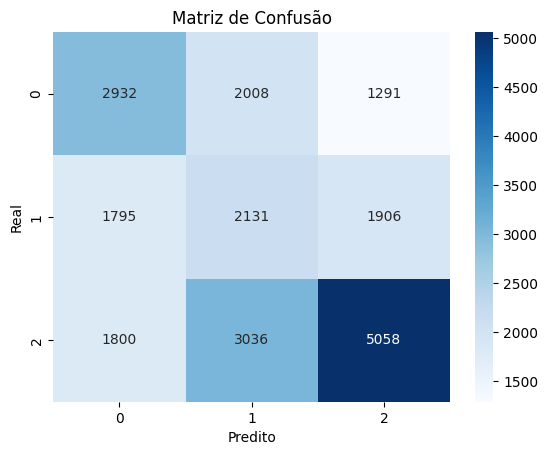


== Arquitetura 4: [40, 20, 10] ==
Epoch 0 - Loss: 1.1082 | Val Loss: 1.1084 | Val Acc: 0.2656
Epoch 100 - Loss: 1.0762 | Val Loss: 1.0761 | Val Acc: 0.4583
Epoch 200 - Loss: 1.0378 | Val Loss: 1.0398 | Val Acc: 0.4572
Epoch 300 - Loss: 1.0303 | Val Loss: 1.0337 | Val Acc: 0.4578
Epoch 400 - Loss: 1.0290 | Val Loss: 1.0327 | Val Acc: 0.4606
Acurácia: 46.17%


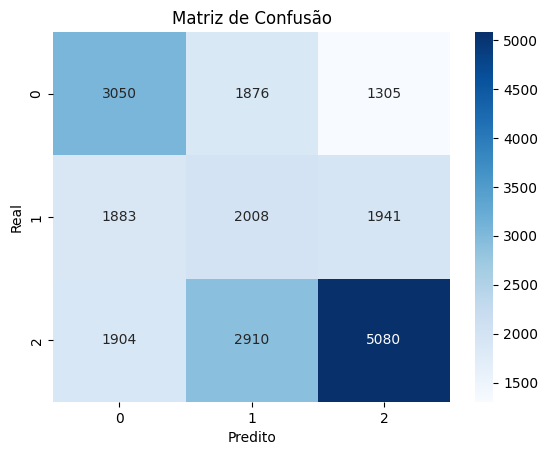


== Arquitetura 5: [80, 40, 20, 10] ==
Epoch 0 - Loss: 1.1200 | Val Loss: 1.1169 | Val Acc: 0.2838
Epoch 100 - Loss: 1.0938 | Val Loss: 1.0937 | Val Acc: 0.4521
Epoch 200 - Loss: 1.0705 | Val Loss: 1.0702 | Val Acc: 0.4603
Epoch 300 - Loss: 1.0496 | Val Loss: 1.0504 | Val Acc: 0.4548
Epoch 400 - Loss: 1.0414 | Val Loss: 1.0433 | Val Acc: 0.4603
Acurácia: 46.50%


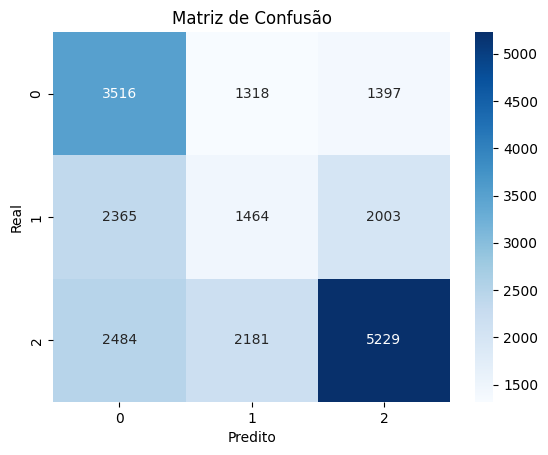

In [ ]:
# === 7. Treinamento com diferentes arquiteturas ===
architectures = [
    [],
    [10],
    [20, 10],
    [40, 20, 10],
    [80, 40, 20, 10]
]

histories = []
accuracies = []

for i, arch in enumerate(architectures):
    print(f"\n== Arquitetura {i+1}: {arch} ==")
    model = MLP(input_size=X_train.shape[1], hidden_sizes=arch).to(device)
    history = train(model, X_train, y_train, X_test, y_test, epochs=500, lr=0.1)
    evaluate(model, X_test, y_test)
    histories.append((f"Arch {i+1}: {arch}", history))
    accuracies.append(history['val_acc'][-1])


In [ ]:
# 📌 Identifique a melhor arquitetura:
best_idx = np.argmax(accuracies)
print(f"\nMelhor arquitetura sem momentum: {architectures[best_idx]} (Acurácia: {accuracies[best_idx]*100:.2f}%)")



Melhor arquitetura sem momentum: [80, 40, 20, 10] (Acurácia: 46.50%)



== Repetindo melhor arquitetura COM momentum ==
Epoch 0 - Loss: 1.1073 | Val Loss: 1.1077 | Val Acc: 0.2656
Epoch 100 - Loss: 1.0290 | Val Loss: 1.0326 | Val Acc: 0.4766
Epoch 200 - Loss: 1.0273 | Val Loss: 1.0314 | Val Acc: 0.4670
Epoch 300 - Loss: 1.0268 | Val Loss: 1.0311 | Val Acc: 0.4650
Epoch 400 - Loss: 1.0264 | Val Loss: 1.0308 | Val Acc: 0.4639
Acurácia: 46.40%


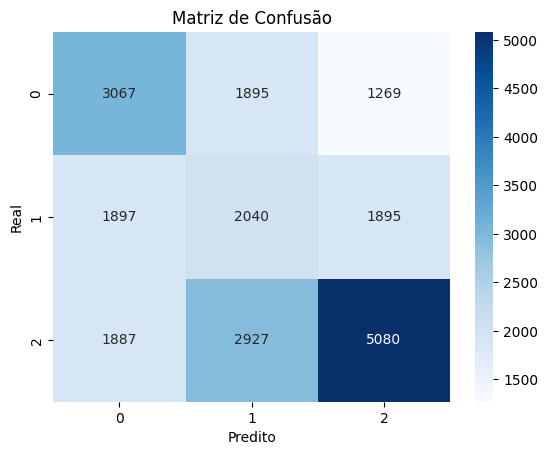

In [ ]:
# 🔁 Treine novamente a melhor arquitetura com momentum:
print("\n== Repetindo melhor arquitetura COM momentum ==")
best_arch = architectures[best_idx]
model_momentum = MLP(input_size=X_train.shape[1], hidden_sizes=best_arch).to(device)
history_momentum = train(model_momentum, X_train, y_train, X_test, y_test, epochs=500, lr=0.1, momentum=0.9)
evaluate(model_momentum, X_test, y_test)


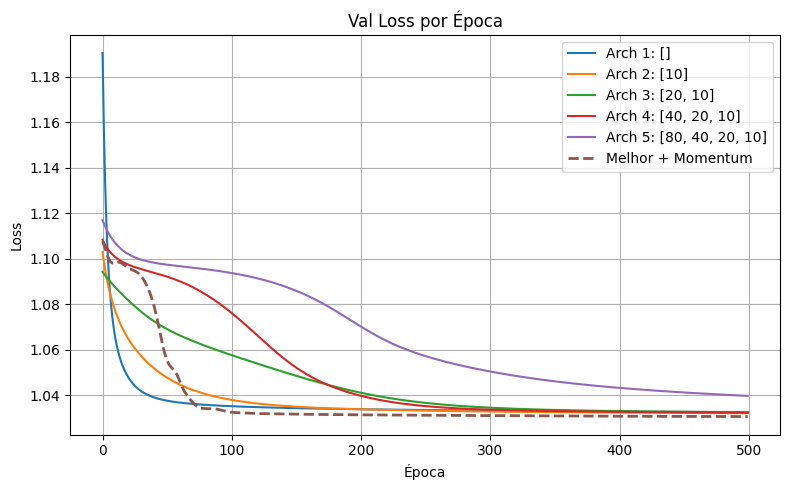

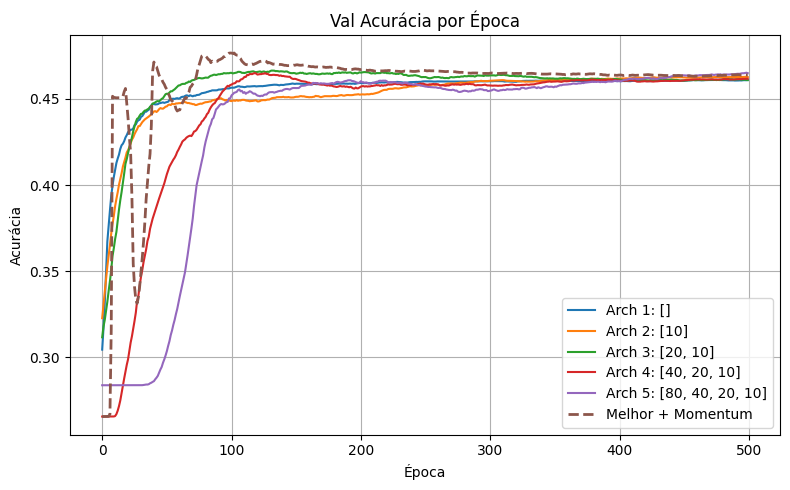

In [ ]:
# 📈 Plote os gráficos:
def plot_loss(histories, history_momentum=None):
    plt.figure(figsize=(8, 5))
    for name, hist in histories:
        plt.plot(hist['val_loss'], label=name)
    if history_momentum:
        plt.plot(history_momentum['val_loss'], label='Melhor + Momentum', linestyle='--', linewidth=2)
    plt.title("Val Loss por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("grafico_loss.png")  # opcional
    plt.show()

def plot_accuracy(histories, history_momentum=None):
    plt.figure(figsize=(8, 5))
    for name, hist in histories:
        plt.plot(hist['val_acc'], label=name)
    if history_momentum:
        plt.plot(history_momentum['val_acc'], label='Melhor + Momentum', linestyle='--', linewidth=2)
    plt.title("Val Acurácia por Época")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("grafico_acc.png")  # opcional
    plt.show()

plot_loss(histories, history_momentum)
plot_accuracy(histories, history_momentum)
